<a href="https://colab.research.google.com/github/HelgaHanemer/SF-Data-Science/blob/Initial-commit/toxicity_project/toxicity_sf_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><strong>Предсказание токсичности химических соединений (RandomForest)</strong></h1>


Этот ноутбук создан для учебного проекта и показывает полный пайплайн:
1) Анализ и визуализация данных
2) Предобработка и генерация признаков из SMILES с помощью **RDKit**
3) Обучение модели **RandomForestRegressor** (простое разбиение train/val)
4) Оценка по **RMSE**
5) Инференс на тестовом наборе `test_only_smiles.csv` и сохранение `predictions.csv`


## Установка и импорт библиотек

In [20]:
!pip -q install rdkit pandas scikit-learn matplotlib seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List
from dataclasses import dataclass

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


## Загрузка данных

In [21]:

# Путь к файлам
TRAIN_PATH = 'train.csv'
TEST_PATH  = 'test_only_smiles.csv'

# Загрузка
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

# Унификация имен столбцов
if 'Unnamed: 0' in test_df.columns and 'id' not in test_df.columns:
    test_df = test_df.rename(columns={'Unnamed: 0': 'id'})
if 'id' not in test_df.columns:
    test_df.insert(0, 'id', range(len(test_df)))

display(train_df.head())
display(test_df.head())

assert 'SMILES' in train_df.columns, "В train.csv должен быть столбец 'SMILES'"
assert 'activity' in train_df.columns, "В train.csv должен быть столбец 'activity'"
assert 'SMILES' in test_df.columns, "В test_only_smiles.csv должен быть столбец 'SMILES'"


,SMILES,activity
0,OCC=C,5.0
1,CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1,94.0
2,COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,5.4
3,CCCCC(CC)C(O)=O,-8.2
4,COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...,26.2


,id,SMILES
0,0,CC(O)CCO
1,1,CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C=C1
2,2,CO/N=C(/C1=NOCCO1)\C2=C(OC3=NC=NC(OC4=CC=CC=C4...
3,3,C=CC(=O)NCNC(=O)C=C
4,4,CC1=CC(=CC=C1)[N+]([O-])=O


## Анализ данных (EDA)

In [22]:

# Размеры и базовые проверки
print("Размер train:", train_df.shape)
print("Размер test :", test_df.shape)
print("\nПропуски в train:")
print(train_df.isna().sum())
print("\nДубликаты SMILES в train:", train_df['SMILES'].duplicated().sum())

# Статистика по целевой переменной
print("\nОписательная статистика по activity:")
display(train_df['activity'].describe())

Размер train: (759, 2)
Размер test : (253, 2)

Пропуски в train:
SMILES      0
activity    0
dtype: int64

Дубликаты SMILES в train: 0

Описательная статистика по activity:


,activity
count,759.000000
mean,40.691304
std,36.150662
min,-38.300000
25%,10.750000
50%,30.100000
75%,69.550000
max,111.000000


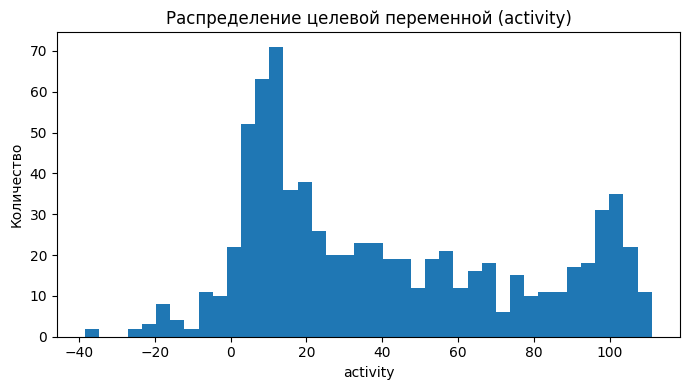

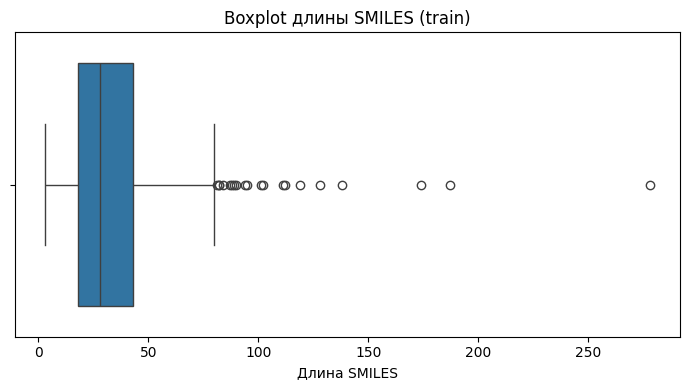

In [23]:
# Длина SMILES как простой индикатор размера/сложности
train_df['smiles_len'] = train_df['SMILES'].str.len()
test_df['smiles_len']  = test_df['SMILES'].str.len()

plt.figure(figsize=(7,4))
plt.hist(train_df['activity'], bins=40)
plt.title('Распределение целевой переменной (activity)')
plt.xlabel('activity')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x=train_df['smiles_len'])
plt.title('Boxplot длины SMILES (train)')
plt.xlabel('Длина SMILES')
plt.ylabel('')
plt.tight_layout()
plt.show()

>*Вывод:* распределение `activity` широкое и правосторонне асимметричное: доля высоких значений выше, чем можно ожидать при нормальном распределении. Это намекает на неоднородность выборки и возможное существование «классов» по токсичности; для моделей это может означать большую дисперсию ошибок в верхнем хвосте.


**Небольшие выводы по EDA:**  
- Пропусков нет, формат данных корректный.  
- Распределение `activity` широкое и может иметь асимметрию/выбросы.  
- Длины SMILES варьируются, встречаются длинные последовательности (крупные молекулы).  


## Генерация признаков из SMILES (RDKit)

In [24]:

def featurize_molecule(smiles: str) -> List[float]:
    """
    Вычисляет набор молекулярных дескрипторов для данного соединения.

    :param smiles: SMILES-строка молекулы.
    :return: Список из 13 дескрипторов (MolWt, MolLogP, HeavyAtomCount, ...).
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # Если SMILES некорректен, вернём NaN-и, чтобы потом можно было обработать
        return [np.nan]*13

    descriptor_funcs = [
        Descriptors.MolWt,
        Crippen.MolLogP,
        Lipinski.HeavyAtomCount,
        Lipinski.FractionCSP3,
        Lipinski.NOCount,
        Lipinski.NumHAcceptors,
        Lipinski.NumHDonors,
        Lipinski.NumHeteroatoms,
        Lipinski.NumRotatableBonds,
        Lipinski.RingCount,
        Lipinski.NumAromaticRings,
        Lipinski.NumAliphaticRings,
        Lipinski.NumSaturatedRings,
    ]
    features = [func(mol) for func in descriptor_funcs]
    return features

FEATURE_NAMES = [
    "MolWt","MolLogP","HeavyAtomCount","FractionCSP3","NOCount",
    "NumHAcceptors","NumHDonors","NumHeteroatoms","NumRotatableBonds",
    "RingCount","NumAromaticRings","NumAliphaticRings","NumSaturatedRings"
]

# Применяем к train/test
X_train_feats = np.array([featurize_molecule(s) for s in train_df['SMILES']])
X_test_feats  = np.array([featurize_molecule(s) for s in test_df['SMILES']])

# В редких случаях могут быть NaN, удалим соответствующие образцы из train
mask_ok = ~np.isnan(X_train_feats).any(axis=1)
if mask_ok.sum() < len(mask_ok):
    print(f"Предупреждение: удаляем {len(mask_ok)-mask_ok.sum()} образцов с некорректными SMILES из train.")
X_train_feats = X_train_feats[mask_ok]
y = train_df.loc[mask_ok, 'activity'].values

# Признаки как DataFrame для удобства анализа
X_train_df = pd.DataFrame(X_train_feats, columns=FEATURE_NAMES)
X_test_df  = pd.DataFrame(X_test_feats,  columns=FEATURE_NAMES)

display(X_train_df.head())


,MolWt,MolLogP,HeavyAtomCount,FractionCSP3,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,RingCount,NumAromaticRings,NumAliphaticRings,NumSaturatedRings
0,58.080,0.16470,4.0,0.333333,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,313.353,3.09752,23.0,0.222222,5.0,5.0,0.0,5.0,6.0,2.0,2.0,0.0,0.0
2,230.245,0.31350,15.0,0.125000,6.0,5.0,2.0,7.0,2.0,1.0,1.0,0.0,0.0
3,144.214,2.28740,10.0,0.875000,2.0,1.0,1.0,2.0,5.0,0.0,0.0,0.0,0.0
4,396.381,4.51650,26.0,0.562500,4.0,5.0,0.0,10.0,5.0,2.0,1.0,1.0,0.0


### Дополнительные визуализации (EDA)

- Распределения **MolWt** и **MolLogP**
- Scatter **MolWt vs activity** с трендовой линией (polyfit)


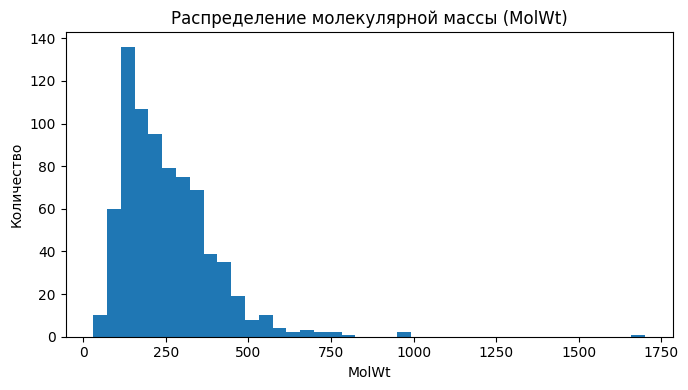

In [25]:

# Гистограмма MolWt (только matplotlib)
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(X_train_df['MolWt'].values, bins=40)
plt.title('Распределение молекулярной массы (MolWt)')
plt.xlabel('MolWt')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()


>*Вывод:* большинство молекул имеют умеренную массу, но правый хвост отражает наличие тяжёлых структур. Это объясняет положительную связь массы с токсичностью и возможное влияние нескольких тяжёлых образцов на обучение.

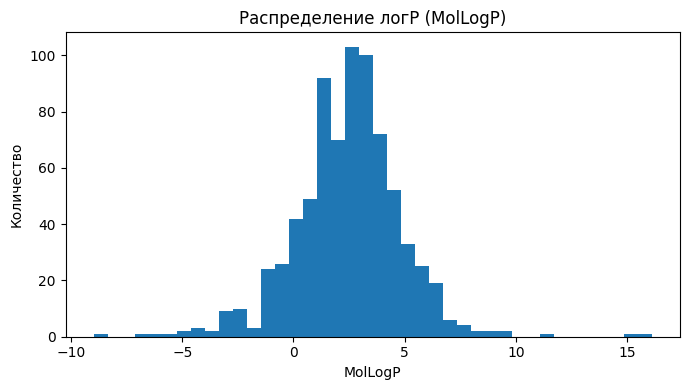

In [26]:

# Гистограмма MolLogP (только matplotlib)
plt.figure(figsize=(7,4))
plt.hist(X_train_df['MolLogP'].values, bins=40)
plt.title('Распределение логP (MolLogP)')
plt.xlabel('MolLogP')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()


>*Вывод:* спектр `MolLogP` покрывает от гидрофильных до гидрофобных молекул, медианные значения — умеренно гидрофобные. Чем выше гидрофобность, тем чаще соединение проникает в липофильные среды, что может усиливать токсический эффект.

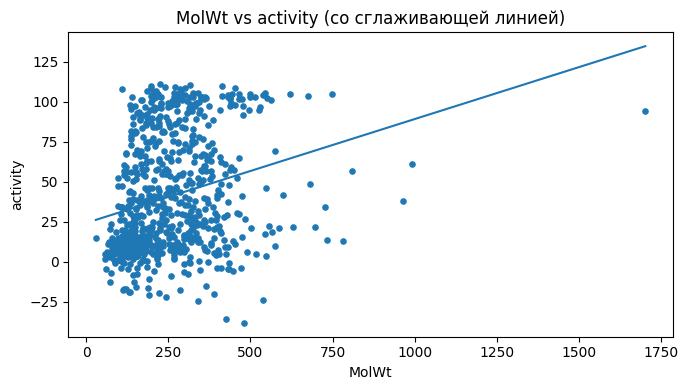

In [27]:

# Scatter MolWt vs activity + трендовая линия (polyfit)
import numpy as np

x = X_train_df['MolWt'].values
y_local = y  # activity после маски

plt.figure(figsize=(7,4))
plt.scatter(x, y_local, s=14)
# Трендовая линия первой степени
coef = np.polyfit(x, y_local, 1)
p = np.poly1d(coef)
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, p(xs))
plt.title('MolWt vs activity (со сглаживающей линией)')
plt.xlabel('MolWt')
plt.ylabel('activity')
plt.tight_layout()
plt.show()


>*Вывод:* тренд указывает на рост `activity` с увеличением `MolWt`, хотя разброс высок. Это подтверждает, что масса — важный, но не единственный фактор токсичности.

### Ещё визуализации (EDA, только matplotlib)

- Scatter **MolLogP vs activity** с трендовой линией
- Scatter **NumAromaticRings vs activity** с трендовой линией
- **Boxplot activity** по квинтилям **MolWt**

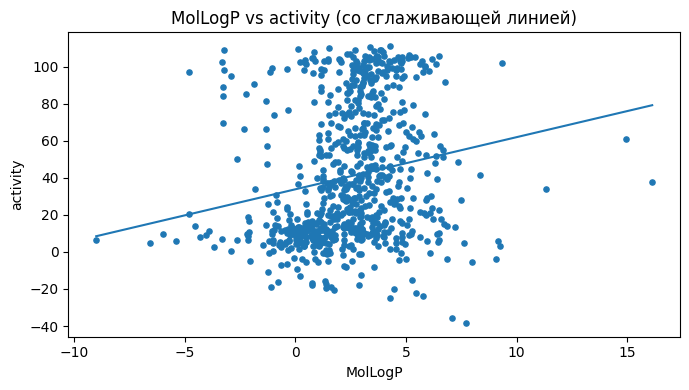

In [28]:

# Scatter MolLogP vs activity + трендовая линия
import numpy as np
import matplotlib.pyplot as plt

x = X_train_df['MolLogP'].values
y_local = y

plt.figure(figsize=(7,4))
plt.scatter(x, y_local, s=14)
coef = np.polyfit(x, y_local, 1)
p = np.poly1d(coef)
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, p(xs))
plt.title('MolLogP vs activity (со сглаживающей линией)')
plt.xlabel('MolLogP')
plt.ylabel('activity')
plt.tight_layout()
plt.show()


>*Вывод:* наблюдается положительный тренд: более гидрофобные соединения, как правило, токсичнее, но дисперсия существенная. Вероятно, эффект проявляется совместно с другими признаками (размер, ароматичность).

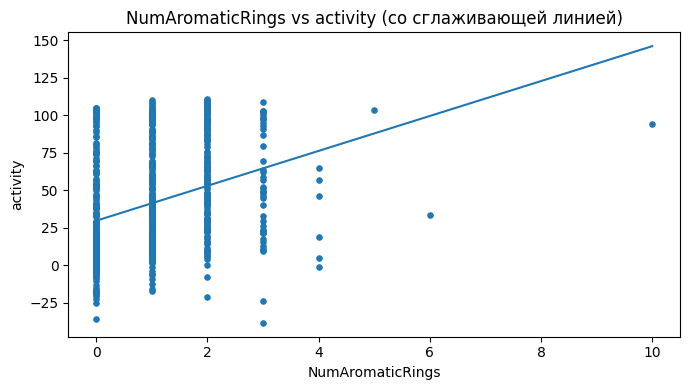

In [29]:

# Scatter NumAromaticRings vs activity + трендовая линия
import numpy as np
import matplotlib.pyplot as plt

x = X_train_df['NumAromaticRings'].values
y_local = y

plt.figure(figsize=(7,4))
plt.scatter(x, y_local, s=14)
coef = np.polyfit(x, y_local, 1)
p = np.poly1d(coef)
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, p(xs))
plt.title('NumAromaticRings vs activity (со сглаживающей линией)')
plt.xlabel('NumAromaticRings')
plt.ylabel('activity')
plt.tight_layout()
plt.show()


>*Вывод:* увеличение числа ароматических колец связано с ростом `activity`; ароматичность — маркёр потенциальной токсичности. Однако линейная зависимость не идеальна — значима и композиция кольцевых систем.

/tmp/ipython-input-2383341968.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=True)


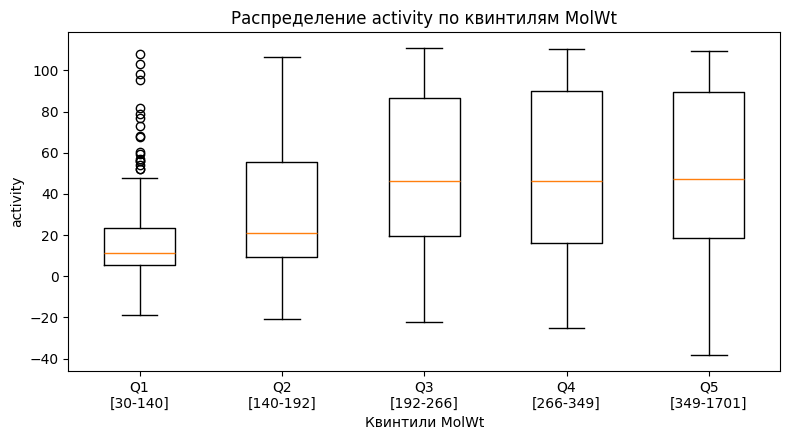

In [30]:

# Boxplot activity по квинтилям MolWt (только matplotlib)
import numpy as np
import matplotlib.pyplot as plt

molwt = X_train_df['MolWt'].values
y_local = y

# Квинтильные пороги
qs = np.quantile(molwt, [0, 0.2, 0.4, 0.6, 0.8, 1.0])
labels = [f"Q{i+1}\n[{qs[i]:.0f}-{qs[i+1]:.0f}]" for i in range(5)]

# Разбиение на группы
groups = [[] for _ in range(5)]
for val, target in zip(molwt, y_local):
    for i in range(5):
        if qs[i] <= val <= qs[i+1] if i == 4 else (qs[i] <= val < qs[i+1]):
            groups[i].append(target)
            break

plt.figure(figsize=(8,4.5))
plt.boxplot(groups, labels=labels, showfliers=True)
plt.title('Распределение activity по квинтилям MolWt')
plt.xlabel('Квинтили MolWt')
plt.ylabel('activity')
plt.tight_layout()
plt.show()


>*Вывод:* медиана `activity` возрастает от лёгких к тяжёлым молекулам; при этом распределения перекрываются. Следовательно, одного `MolWt` недостаточно для точного прогноза — нужна комбинация признаков.

,activity
NumAromaticRings,0.332831
MolWt,0.253511
NumHeteroatoms,0.230802
HeavyAtomCount,0.227576
MolLogP,0.187273
RingCount,0.143653
NumHAcceptors,0.111073
NumRotatableBonds,0.080005
NOCount,0.072579
NumHDonors,0.066615


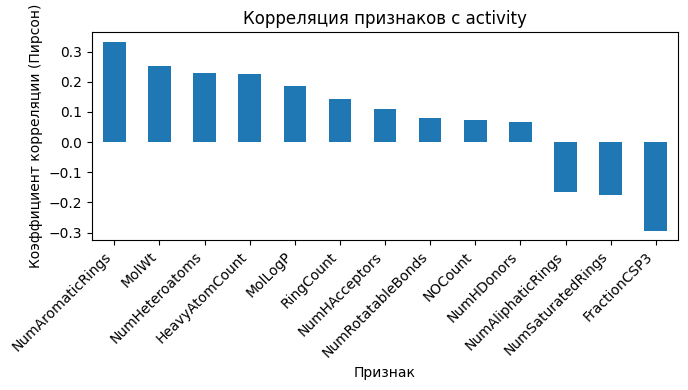

In [31]:

# Корреляция признаков с целевой
corr_with_target = X_train_df.join(pd.Series(y, name='activity')).corr()['activity'].drop('activity')
display(corr_with_target.sort_values(ascending=False))

plt.figure(figsize=(7,4))
corr_with_target.sort_values(ascending=False).plot(kind='bar')
plt.title('Корреляция признаков с activity')
plt.xlabel('Признак')
plt.ylabel('Коэффициент корреляции (Пирсон)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


>*Вывод:* признаки размера/ароматичности (MolWt, NumAromaticRings) положительно связаны с токсичностью, тогда как `FractionCSP3` — отрицательно. В сумме это соответствует химической интуиции: более тяжёлые и ароматические молекулы чаще оказываются токсичнее.

### Тепловая карта корреляций признаков

Тепловая карта корреляций между всеми сгенерированными признаками RDKit помогает увидеть группы сильно зависимых признаков и потенциальную мультиколлинеарность.

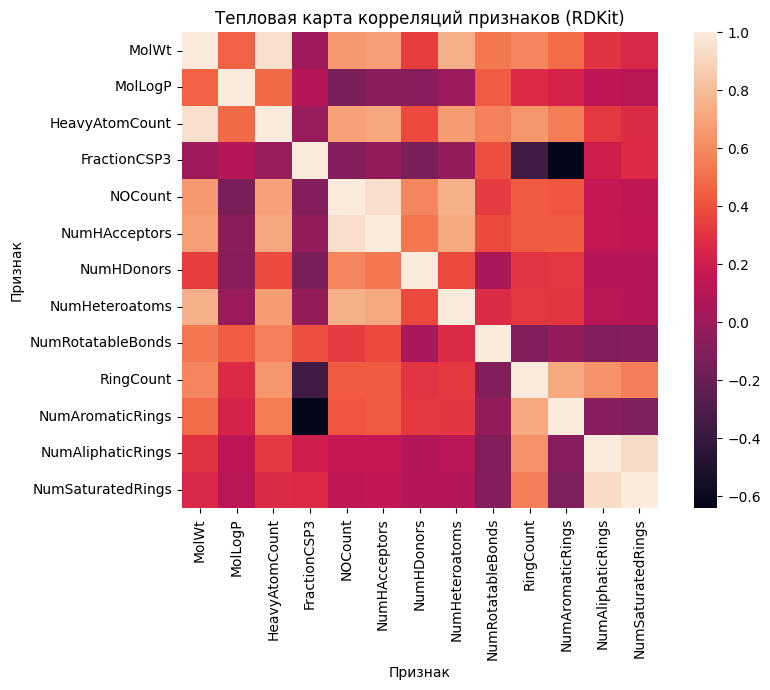

In [32]:

# Тепловая карта корреляций между признаками
plt.figure(figsize=(9, 7))
corr_matrix = X_train_df.corr()
import seaborn as sns
sns.heatmap(corr_matrix, annot=False, square=True)
plt.title('Тепловая карта корреляций признаков (RDKit)')
plt.xlabel('Признак')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()


>*Вывод:* видны кластеры коррелирующих показателей (например, размерные и кольцевые признаки), что указывает на мультиколлинеарность. Для деревьев это не критично, но для линейных моделей потребовалась бы регуляризация или отбор признаков.


*Комментарий:* признаки, связанные с размером и ароматичностью (например, `MolWt`, `NumAromaticRings`)
часто положительно коррелируют с токсичностью, в то время как насыщенность (`FractionCSP3`) — отрицательно.


## Обучение модели RandomForest и оценка (RMSE)

In [33]:

def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Считает корень среднеквадратичной ошибки (RMSE).
    """
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# Разделяем на train/val (простое разбиение)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_feats, y, test_size=0.2, random_state=42
)

# Обучаем RandomForest
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_tr, y_tr)

# Оценка
y_tr_pred  = rf.predict(X_tr)
y_val_pred = rf.predict(X_val)

rmse_tr  = rmse(y_tr, y_tr_pred)
rmse_val = rmse(y_val, y_val_pred)

print(f"RMSE (train): {rmse_tr:.3f}")
print(f"RMSE (val)  : {rmse_val:.3f}")


RMSE (train): 9.936
RMSE (val)  : 27.131


,0
MolLogP,0.169512
MolWt,0.156041
FractionCSP3,0.125815
HeavyAtomCount,0.104807
NumHeteroatoms,0.086779
NumRotatableBonds,0.073690
NumAromaticRings,0.071866
NOCount,0.056586
NumHDonors,0.047714
NumHAcceptors,0.044304


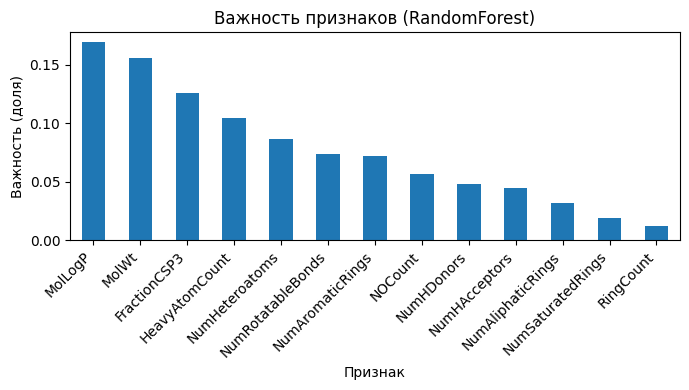

In [34]:

# Важности признаков
importances = rf.feature_importances_
fi = pd.Series(importances, index=FEATURE_NAMES).sort_values(ascending=False)
display(fi)

plt.figure(figsize=(7,4))
fi.plot(kind='bar')
plt.title('Важность признаков (RandomForest)')
plt.xlabel('Признак')
plt.ylabel('Важность (доля)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


>*Вывод:* модель делает упор на размер (MolWt), гидрофобность (MolLogP) и структурные индикаторы (FractionCSP3/кольца). Это согласуется с EDA и повышает интерпретируемость прогноза.


**Короткие выводы по модели:**  
- Случайный лес улавливает нелинейные зависимости и даёт разумную точность на валидации.  
- Наиболее важные признаки, как правило, связаны с размером молекулы и гидрофобностью (например, `MolWt`, `MolLogP`) и ароматичностью.  


## Финальная модель и предсказания на тесте

In [35]:

# Дообучаем на всех доступных обучающих данных
final_rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
final_rf.fit(X_train_feats, y)

# Предсказания на тестовом наборе
y_test_pred = final_rf.predict(X_test_df.values)

predictions = pd.DataFrame({
    'id': test_df['id'].values,
    'SMILES': test_df['SMILES'].values,
    'PredictedActivity': y_test_pred
})
display(predictions.head(10))

# Сохраняем
SUBMISSION_PATH = 'predictions.csv'
predictions.to_csv(SUBMISSION_PATH, index=False)
print(f"Файл с предсказаниями сохранен: {SUBMISSION_PATH}")


,id,SMILES,PredictedActivity
0,0,CC(O)CCO,9.914500
1,1,CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C=C1,64.283000
2,2,CO/N=C(/C1=NOCCO1)\C2=C(OC3=NC=NC(OC4=CC=CC=C4...,58.263917
3,3,C=CC(=O)NCNC(=O)C=C,14.529708
4,4,CC1=CC(=CC=C1)[N+]([O-])=O,24.333633
5,5,CCCCCCCCCCCCCOP(O)(O)=O,32.779000
6,6,OC(CN1C=NC=N1)(CN2C=NC=N2)C3=C(F)C=C(F)C=C3,53.198500
7,7,CC(C)(C)C(=O)C(OC1=CC=C(Cl)C=C1)N2C=NC=N2,51.349500
8,8,CC(C)(C)N,2.407500
9,9,O=C1NC(=O)C2CC=CCC12,8.835050


Файл с предсказаниями сохранен: predictions.csv



## Итоги

- Проведен анализ данных, визуализация и создан простой, но действенный пайплайн: RDKit-дескрипторы → RandomForest → RMSE.  
- У нас учебный проект, но в дальнейшем качество можно улучшать:  
  1) Обогащать набор признаков (например, Morgan fingerprints, топологические/квантово-химические дескрипторы)  
  2) Настраивать гиперпараметры леса или использовать бустинги (XGBoost/LightGBM)  
  3) Проводить кросс-валидацию для более стабильной оценки качества  
  4) Пробовать модели, работающие с SMILES напрямую (RNN/Transformer)
